In [ ]:
import numpy as np
import xrft
import sys
import matplotlib.pyplot as plt
import os
import xarray as xr
import cmcrameri.cm as cmc

from dask.distributed import Client
import dask
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42911,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:42517,Total threads: 1
Dashboard: /proxy/34539/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:38711,


2024-07-31 16:59:14,259 - distributed.nanny - WARNING - Restarting worker
2024-07-31 16:59:14,295 - distributed.nanny - WARNING - Restarting worker
2024-07-31 16:59:14,591 - distributed.nanny - WARNING - Restarting worker
2024-07-31 16:59:15,598 - distributed.nanny - WARNING - Restarting worker



## Use a 1D toy model initialising from mixed layer mean flow $u_0$. See how it evolves!

$\huge u_0 = \sum A_n \cos(\frac{n \pi z}{H}) $

$\huge u(z,y,t) = \sum A_n \cos(\frac{n \pi z}{H}) cos(\ell y - \omega t) $

To compare with the mom6 model, make some plots of bottom velocity with varying l? 

## Functions borrowed from ttidelib

In [2]:
H = 4000  

l =  np.pi * 2 / 75000


def u_decomp_constN(nmodes,l = np.pi * 2 / 150000,periods= 5,MLdepth = 200,layers = 501,N = 20):
    """
    Decompose velocity for constant N
    """

    u0 = xr.DataArray(
        np.zeros((layers)),
        dims = "zl",
        coords = {"zl": np.linspace(0, H, layers)}
    )


    u0.loc[u0.zl < MLdepth] = 1
    mean = u0.integrate("zl") / 4000
    # mean = 0
    u0 -= mean
    A = (u0 *  ConstEigf(u0.zl,1)).integrate("zl")
    u = u0.expand_dims({"time":np.linspace(0,periods * np.pi * 2 / 1e-4 ,4000)})
    u_out = A * ConstEigf(u.zl,1) * np.cos(OmegaConstN(1,l = l,N=N) * u.time)
    for i in range(2,nmodes):
        A = (u0 *  ConstEigf(u0.zl,i)).integrate("zl")

        u_out += A * ConstEigf(u.zl,i) * np.cos(OmegaConstN(i,l = l,N=N) * u.time)
    return u_out.assign_coords({"time":u.time /3600}) + mean


def ConstEigf(z,n):
    return np.cos(n * np.pi * z / H) / np.sqrt(H/2)


def OmegaConstN(n,l = np.pi * 2 / 150000,N=20):
    """
    This works for constant N, but for variable N eigenfunction code needs to return omega given l,f 
    """
    f = 1e-4                 # Coriolis frequency s.t 2pi / f = 17hrs
    N = N * f               # Buoyancy frequency
    m2 = (n * np.pi / H)**2
    return np.sqrt(
        (N**2 * l**2 + f**2 * m2) / (l**2 + m2)
    )



import xrft

f = 1e-4 / (np.pi * 2)
# f = 0
def supiEnergy(u):
    ps = xrft.power_spectrum(
        u.isel(zl = -1).assign_coords({"time":u.time * 3600}),
        )
    ps = ps.where(np.abs(ps.freq_time) > f,0)
    # ps.sel(freq_time = slice(0,None)).plot(xscale = "log",yscale = "log")
    return ps.sum("freq_time").values

## Make a contour plot of superinertial energy

In [7]:
import dask.array as da
l =  np.pi * 2 / 100000

def _GetSupenergy(l,N):
    
    return supiEnergy(
        u_decomp_constN(100,l = l,N=N)
    )

L = l / (10**np.linspace(-1,1,100))
N =  np.linspace(1,40,100)

# L,N = np.meshgrid(L,N)

_L = L.flatten()
_N = N.flatten()

out = []



# for i in range(len(_L)):
#     for j in range(len(_N)):
#         out.append(dask.delayed(_GetSupenergy)(_L[i],_N[j]))

# results = np.array(dask.compute(out))

# results = results.reshape(np.meshgrid(N,L)[0].shape)


energies = xr.DataArray(
    results,
    dims = ["l","N"],
    coords = {"l":(2 * np.pi / L) / 1000,"N":N}
)

energies.to_netcdf("/g/data/v45/ab8992/forfigure.nc")

In [4]:
# energies.to_netcdf("/g/data/v45/ab8992/bottomiw_energiesforfigure.nc")
energies = xr.open_dataarray("/g/data/v45/ab8992/bottomiw_energiesforfigure.nc")

## Plot all 3 of our theory plots together in one figure

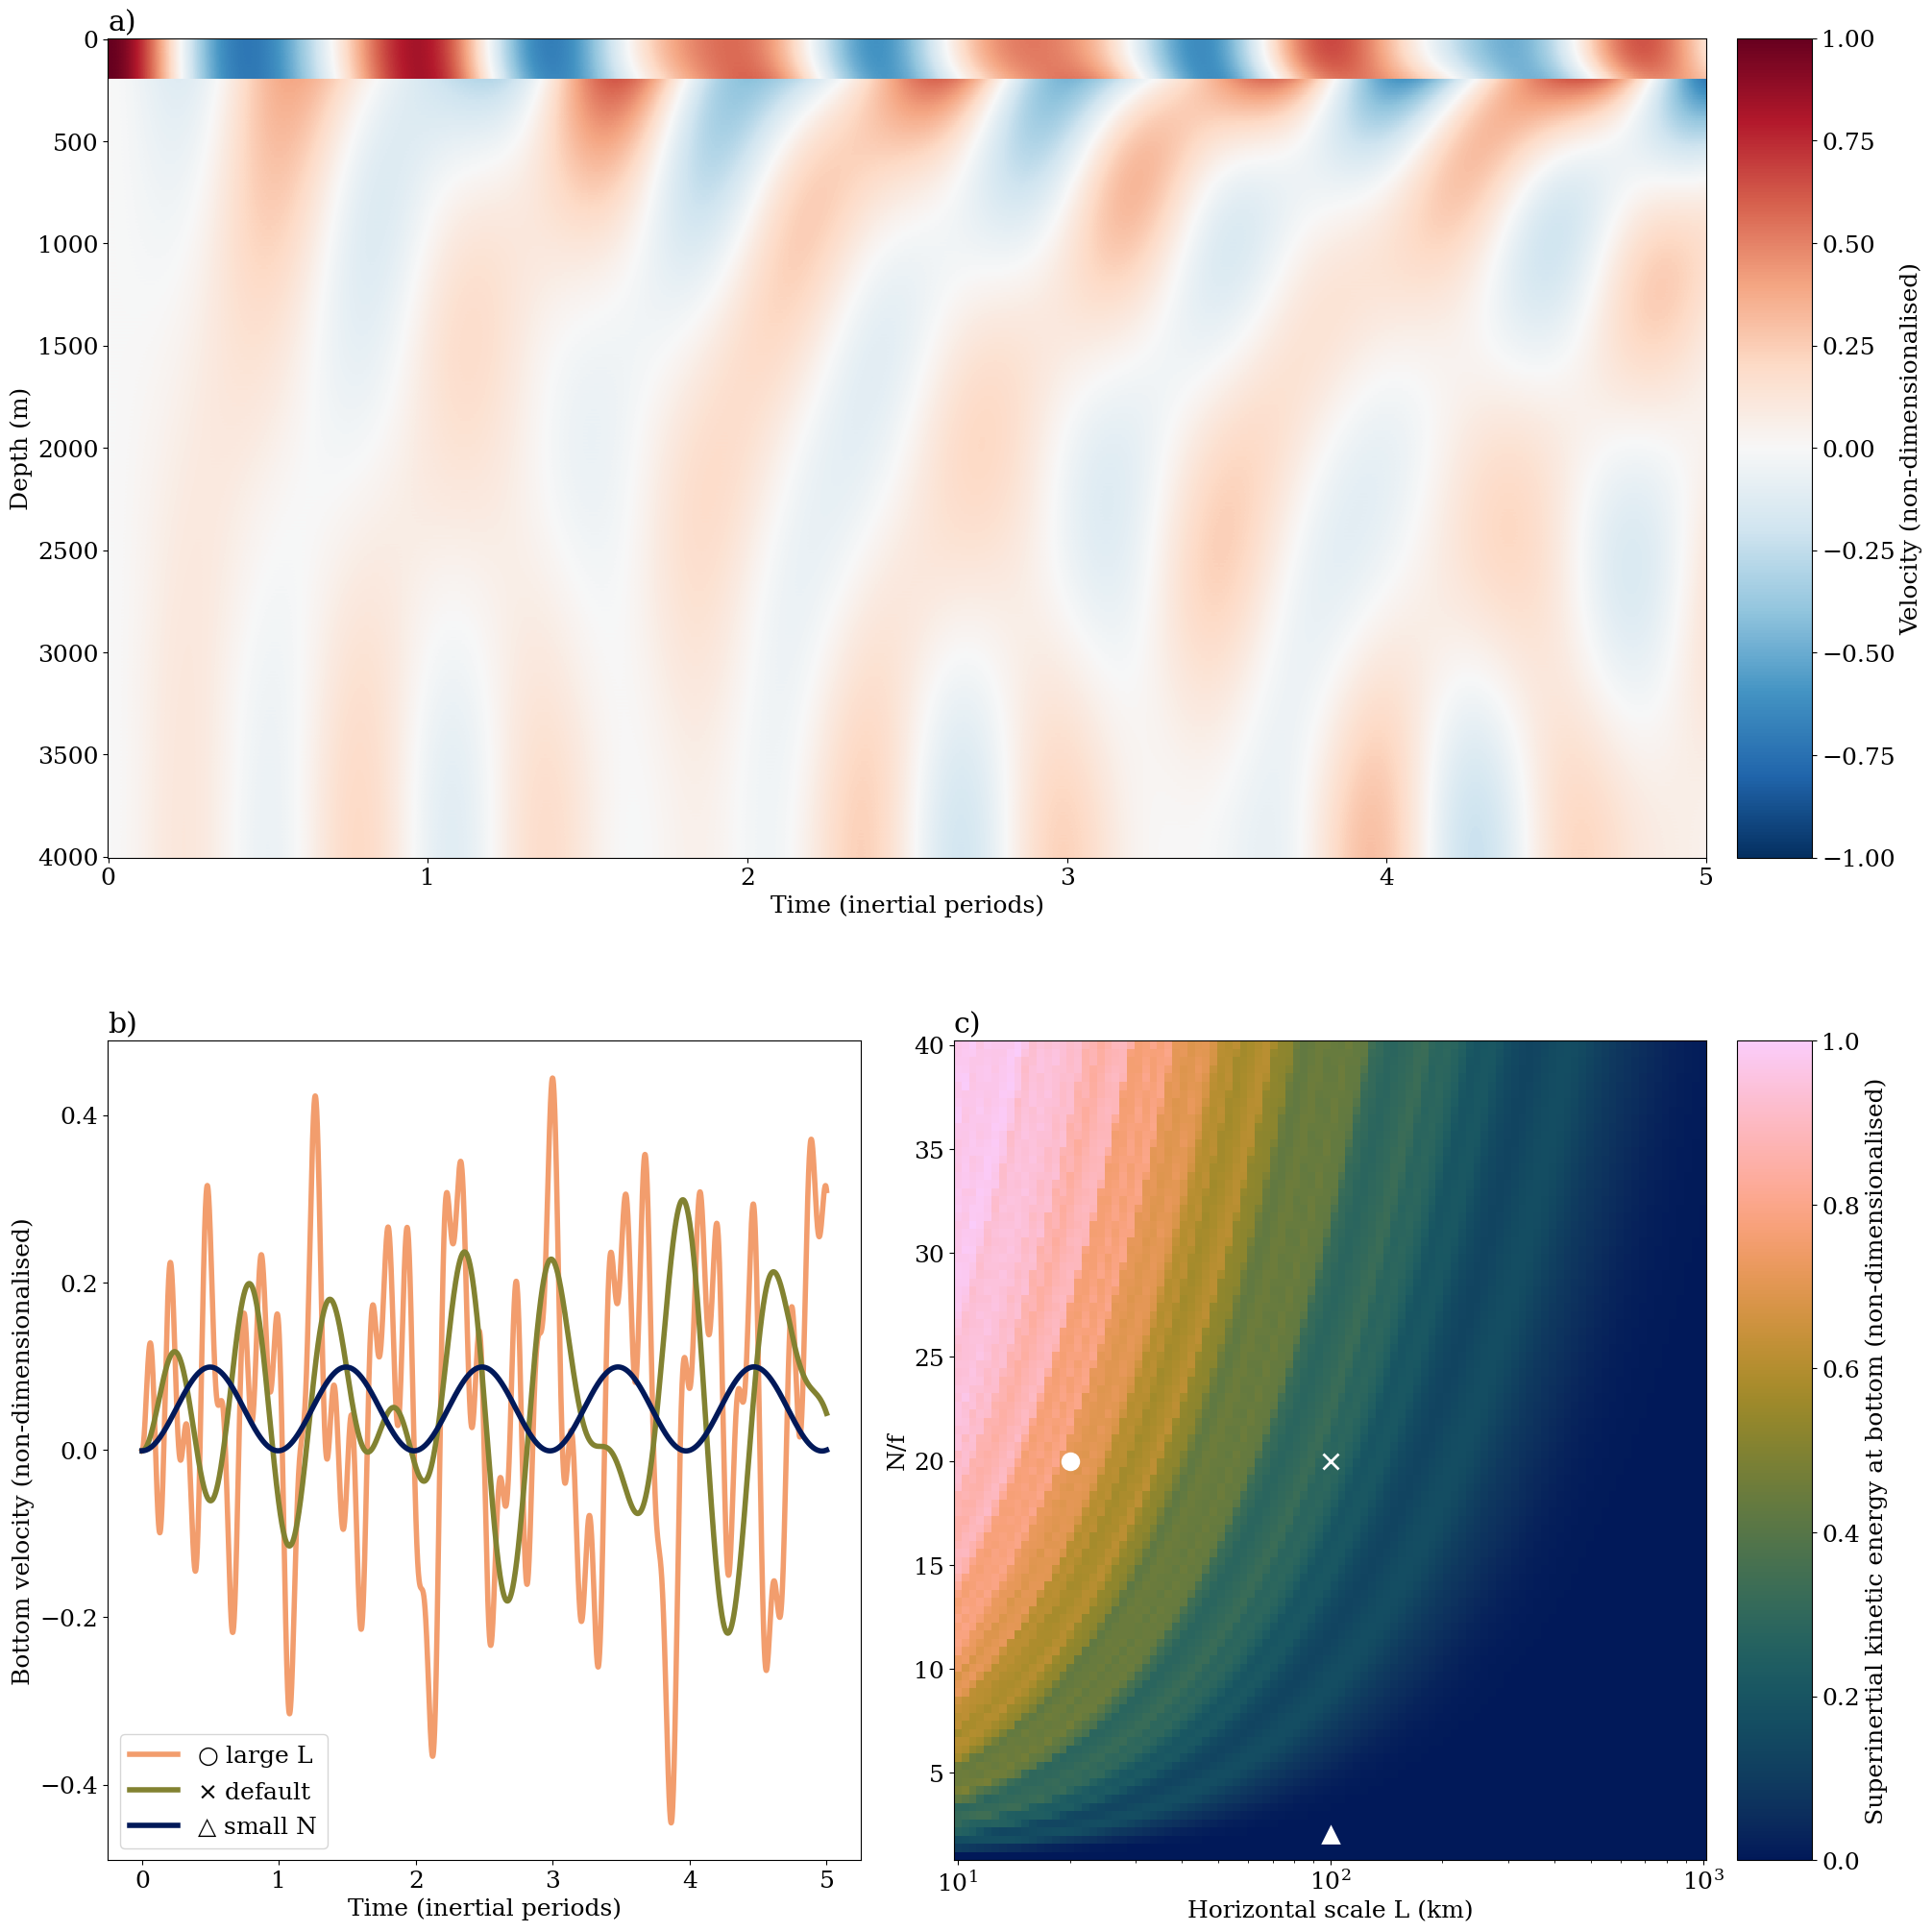

In [34]:
cmap = cmc.batlow

font = {'family' : 'serif',
        'weight':'normal',
        'size'   : 18}
plt.rcParams.update({'font.family': font['family'],
                     'font.weight': font['weight'],
                     'font.size': font['size']})

fig = plt.figure(figsize=(20, 20),constrained_layout=True)
gs = fig.add_gridspec(3, 3,width_ratios=[1,1, 0.1],height_ratios=[1, 0.1,1])

ax1 = fig.add_subplot(gs[0, 0:2])  # First row, spans both columns
ax2 = fig.add_subplot(gs[2, 0])  # Second row, first column
ax3 = fig.add_subplot(gs[2, 1])

cax1 = fig.add_subplot(gs[0, 2])  # First row, second column
cax2 = fig.add_subplot(gs[2, 2])  # First row, second column
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(-1, 1), cmap="RdBu_r"), cax = cax1,label = "Velocity (non-dimensionalised)")
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(0, 1), cmap=cmap), cax=cax2,label = "Superinertial kinetic energy at bottom (non-dimensionalised)")

# u_smallscale = u_decomp_constN(500,l=l * 5,periods = 5)
# u_default = u_decomp_constN(500,l = l,periods = 5)
# u_smallN = u_decomp_constN(500,N = 2,periods = 5)

u_default.rename("u (m/s)").assign_coords({"time":u_default.time / (np.pi * 2 / (3600 * 1e-4))}).plot(ax = ax1,cmap = "RdBu_r",add_colorbar = False)
ax1.invert_yaxis()
ax1.set_xlabel("Time (inertial periods)")
ax1.set_ylabel("Depth (m)")
ax1.set_title("a)",loc = "left")
# ax1.invert_yaxis()
# ax1.set_title(r"Evolution of surface layer velocity with $L = 100km$, $N = 20f$")

c1 = cmap(0)
c2 = cmap(0.5)
c3 = cmap(0.75)

u_smallscale.assign_coords({"time":u_default.time / (np.pi * 2 / (3600 * 1e-4))}).isel(zl = -1).plot(
        ax = ax2,label = r"$\bigcirc$ large L ",color = c3,linewidth = 4
        )
u_default.assign_coords({"time":u_default.time / (np.pi * 2 / (3600 * 1e-4))}).isel(zl = -1).plot(
        ax = ax2,label = r"$\times$ default",color = c2,linewidth = 4
        )
u_smallN.assign_coords({"time":u_default.time / (np.pi * 2 / (3600 * 1e-4))}).isel(zl = -1).plot(
        ax = ax2,label = r"$\bigtriangleup$ small N ",color = c1,linewidth = 4
        )
# u_largel.isel(zl = -1).plot(ax = ax[1,1])
# ax2.set_title("Bottom velocity")
ax2.legend()
ax2.set_title("")
ax2.set_ylabel("Bottom velocity (non-dimensionalised)")
ax2.set_xlabel("Time (inertial periods)")
ax2.set_title("b)",loc = "left")


(energies.sel(l = slice(10,None)).rename("Scaled energy")).plot(ax = ax3,cmap = cmap,y = "N",add_colorbar = False)
ax3.set_xscale("log")
ax3.set_ylabel("N/f")
ax3.set_xlabel("Horizontal scale L (km)")
# ax3.set_title("Superinertial kinetic energy at bottom")
ax3.set_title("c)",loc = "left")
# Add X to show defaul and large l positions

ax3.plot((2 * np.pi / l)/1000, 20, 'x', color='white', markersize=12, markeredgewidth=2)
ax3.plot((2 * np.pi / (l * 5))/1000, 20, 'o', color='white', markersize=12, markeredgewidth=2)
ax3.plot((2 * np.pi / (l))/1000, 2, '^', color='white', markersize=12, markeredgewidth=2)

# plt.tight_layout()



In [70]:
python -m pip install cmcrameri

SyntaxError: invalid syntax (3641979707.py, line 1)

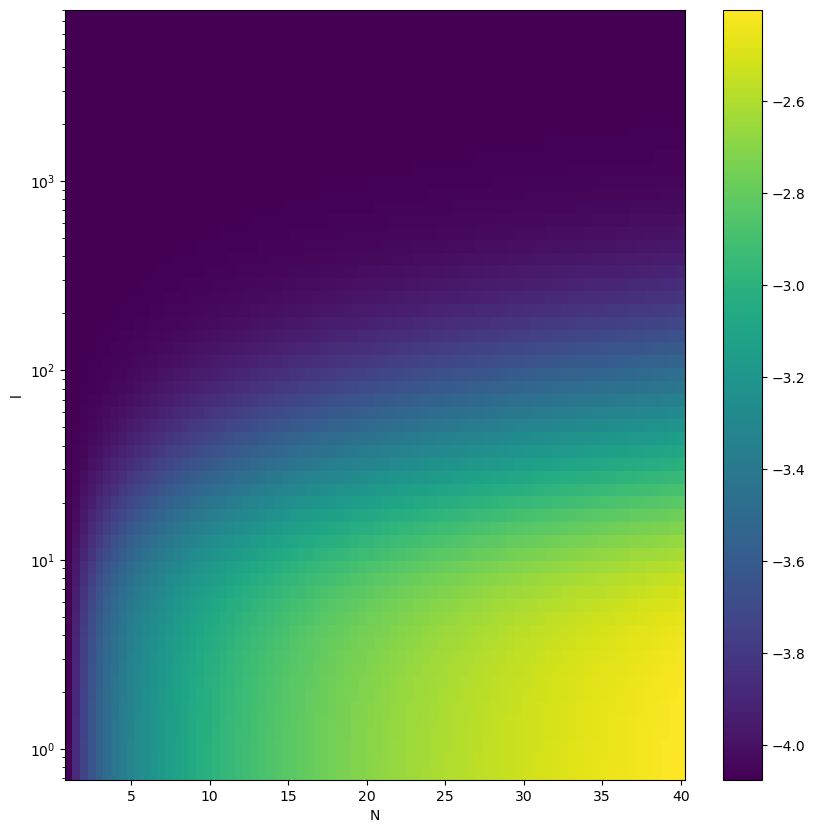

In [23]:
L = l / (10**np.linspace(-2,2,60))
N =  np.linspace(1,40,80)

_L , _N = np.meshgrid(L,N)


om = xr.DataArray(
    OmegaConstN(1,l=_L,N=_N),
    dims = ["N","l"],
    coords = {"l":(2 * np.pi / L) / 1000,"N":N}
)

fig,ax = plt.subplots(1,figsize = (10,10))
np.log10(om - f).plot(ax = ax,y = "l",cmap = "viridis")
ax.set_yscale("log")

